<a href="https://colab.research.google.com/github/JaywonC/Quarter3Capstone/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries (if not already installed)
!pip install yfinance xgboost

# Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
# Fetch historical daily stock data for the past 5 years (e.g., Apple Inc.)
ticker = "AAPL"
df = yf.download(ticker, period="5y")  # fetch last 5 years of data
print("Data shape:", df.shape)
df.head()  # display the first few rows of data


[*********************100%***********************]  1 of 1 completed

Data shape: (1257, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-04-07,62.958225,65.935902,62.853875,65.717485,202887200
2020-04-08,64.569611,64.885090,63.395045,63.761485,168895200
2020-04-09,65.035538,65.540314,64.237129,65.207845,161834800
2020-04-13,66.312035,66.421243,64.511353,65.113200,131022800
2020-04-14,69.661026,69.952244,67.476914,67.950141,194994800


In [ ]:
# Make sure you're working with a clean copy of data with 'Close'
df = yf.download("AAPL", start="2020-01-01", end="2024-01-01")

# Create lag features — yesterday's data to predict tomorrow
df['Close_lag1'] = df['Close'].shift(1)
df['MA5'] = df['Close'].shift(1).rolling(window=5).mean()
df['MA20'] = df['Close'].shift(1).rolling(window=20).mean()

# Target is the next day's price
df['Target'] = df['Close'].shift(-1)

# Drop any rows with NaN values
df.dropna(inplace=True)

# Final feature and target setup
X = df[['Close_lag1', 'MA5', 'MA20']]
y = df['Target']


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Split chronologically
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)


In [ ]:
# Initialize the XGBoost regressor with default parameters
model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror', random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the predictions using common regression metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R^2:  {r2:.2f}")


Test RMSE: 13.41
Test MAE: 10.70
Test R^2:  -0.65


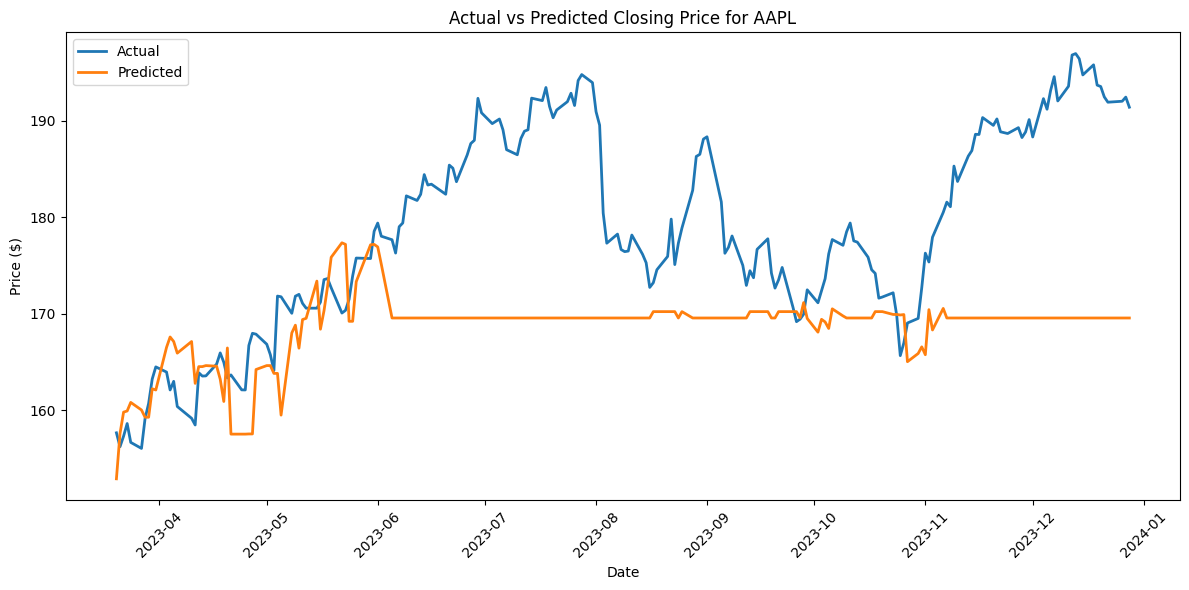

In [ ]:
# Match test set index for date tracking
test_dates = df.index[train_size:]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test, label='Actual', linewidth=2)
plt.plot(test_dates, predictions, label='Predicted', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.title("Actual vs Predicted Closing Price for AAPL")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
